# IMPORT

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

# CREATION DATAFRAMES

In [2]:
targets = ['RES1_BASE', 'RES11_BASE', 'PRO1_BASE', 'RES2_HC', 'RES2_HP', 'PRO2_HC','PRO2_HP']
dfs = []

In [3]:
train = pd.read_csv('train_clean.csv')

In [4]:
for tar in targets:
    temp = targets.copy()
    temp.remove(tar)
    df = train.drop(temp,axis=1)
    df.dropna(inplace=True)
    dfs.append(df)

In [5]:
X_test = pd.read_csv('test_clean.csv')
dfs_test = [x for x in range(len(dfs))]

for i in range(len(dfs)):
    
    df = X_test.copy()
    target = dfs[i].columns[-1]
    dfs_test[i] = df

# TIME SERIES

In [6]:
%matplotlib notebook

datas = []
targets = []

for df in dfs :
    target = df.columns[-1]
    targets.append(target)
    df = df[['Horodate',target]]
    df['Horodate'] = pd.to_datetime(df['Horodate'])
    df.columns = ['date','conso']
    df = df.set_index(df.date)
    df.drop('date',axis=1,inplace=True)
    df['conso'] = pd.to_numeric(df['conso'],downcast='float',errors='coerce')
    datas.append(df)

/home/maxime/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


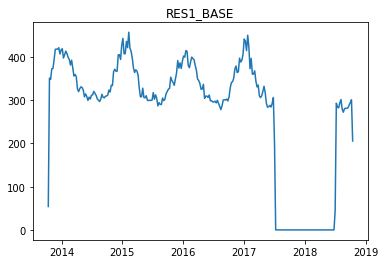

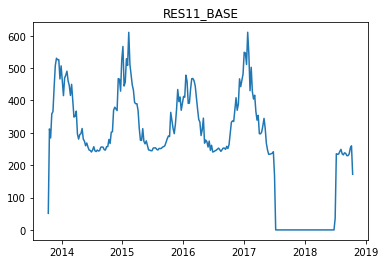

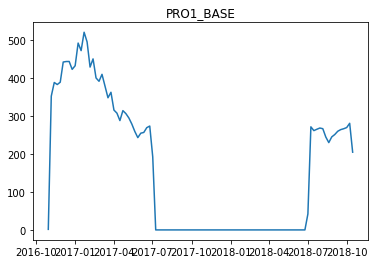

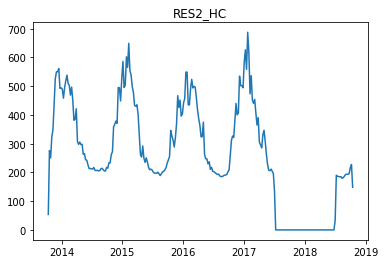

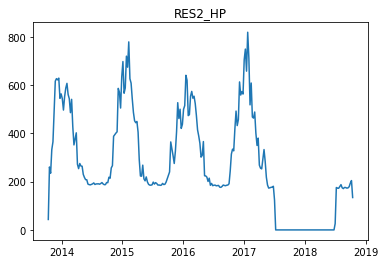

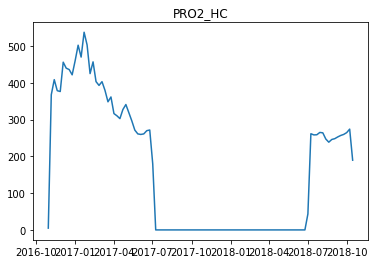

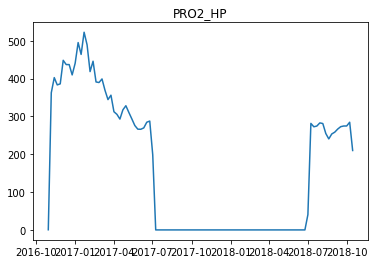

In [7]:
%matplotlib inline
i=0
for data in datas:    
    target = targets[i]
    i+=1
    data['conso'].apply(lambda x: float(x))
    weekly = data.resample('W').sum()
    plt.figure()
    plt.title(target)
    plt.plot(weekly)
    plt.show()

# PROPHET

In [9]:
import fbprophet

In [10]:
start1 = '2013-10-12 22:00:00'
start2 = '2016-10-30 23:00:00'
end = '2018-10-12 21:30:00'
future1 = pd.DataFrame(pd.date_range(start=start1, end=end, freq='30min'),columns=['ds'])
future2 = pd.DataFrame(pd.date_range(start=start2, end=end, freq='30min'),columns=['ds'])

In [11]:
def fill_trend(df,forecast,target):
    
    df = df.set_index(df.Horodate)
    forecast = forecast.set_index(forecast.ds)
    cols = list(forecast.columns)
    cols.remove('yhat')
    df = pd.merge(df,forecast, left_index=True, right_index=True)
    df.drop(cols,axis=1,inplace=True)
    
    if target in list(df.columns):
        cols = list(df.columns)
        cols.remove(target)
        cols.append(target)
        df = df[cols]
        
    df.reset_index(inplace=True)
    df.drop('index',axis=1,inplace=True)
    
    return df

In [12]:
import holidays

hol = {'ds':[],'holiday':[]}

for date, name in sorted(holidays.FRA(years=list(range(2013,2020))).items()):
    hol['ds'].append(date)
    hol['holiday'].append(name)

french_holidays = pd.DataFrame(hol,columns=['ds','holiday'])
french_holidays.head()

,ds,holiday
0,2013-01-01,Jour de l'an
1,2013-04-01,Lundi de Pâques
2,2013-05-01,Fête du Travail
3,2013-05-08,Armistice 1945
4,2013-05-09,Ascension


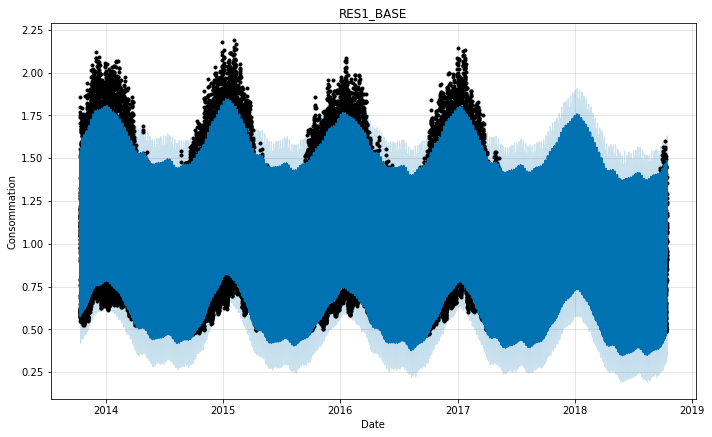

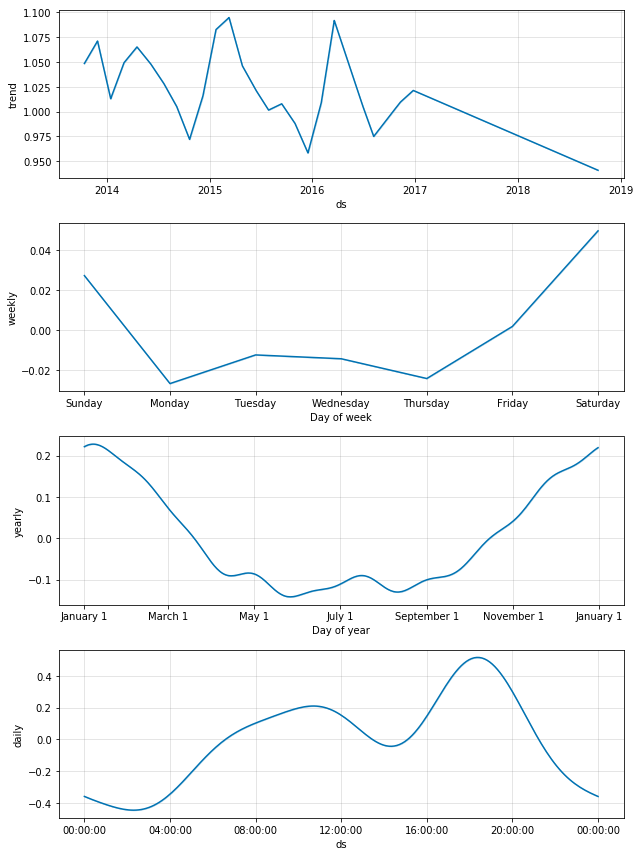

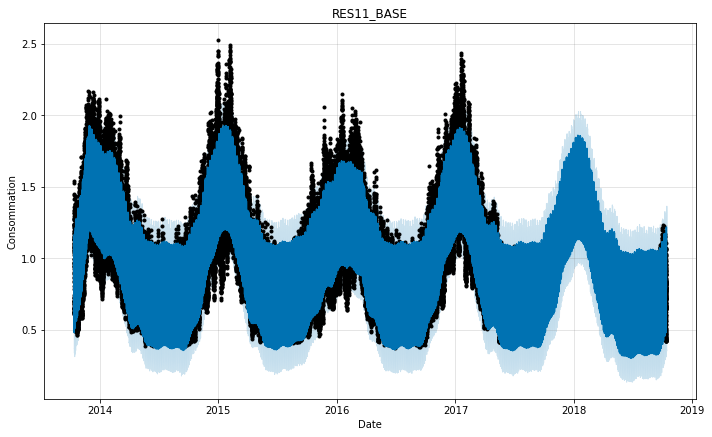

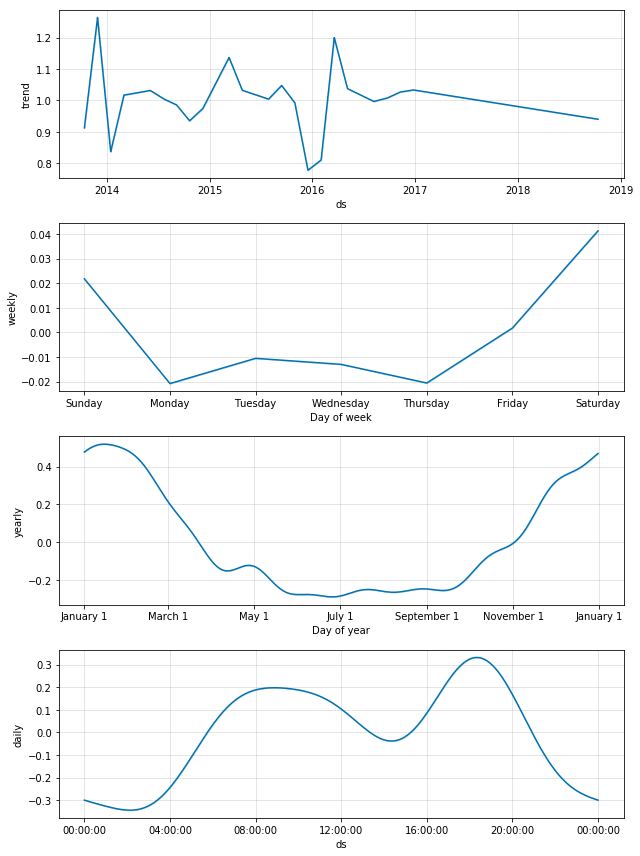

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


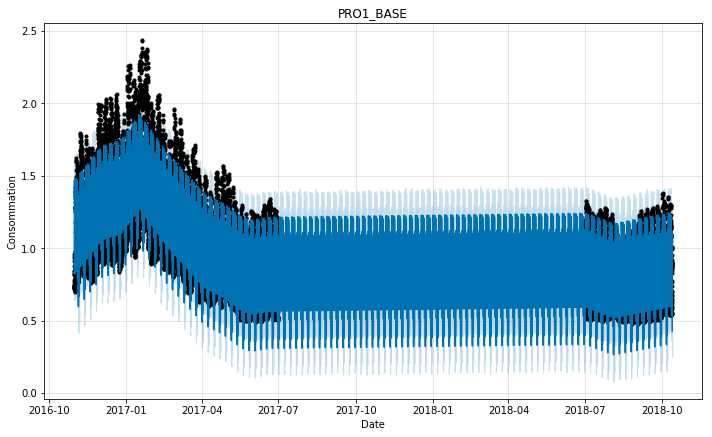

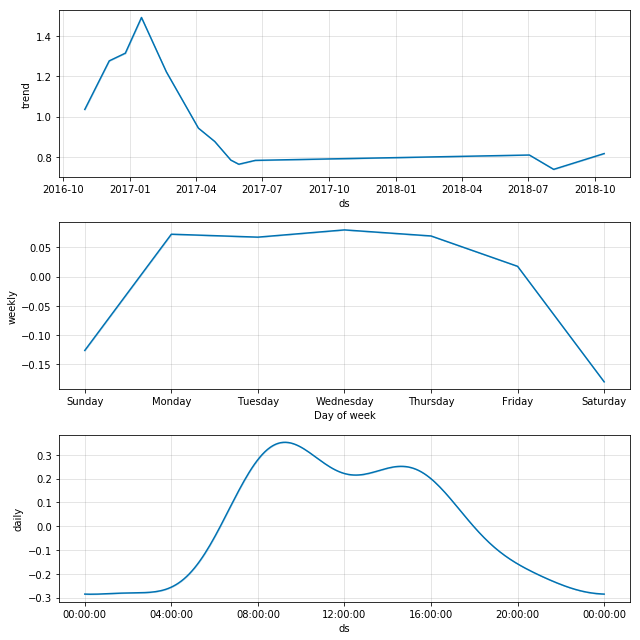

In [ ]:
%%time
from enedis_custom_metric_example import custom_metric_function

i=0
models = []
forecasts = []

for data in datas:

    data.reset_index(inplace=True)
    data = data.rename(columns={'date':'ds','conso':'y'})
    model = fbprophet.Prophet()
    model.fit(data)
    if len(data.index)>20000:
        forecast = model.predict(future1)
    else:
        forecast = model.predict(future2)
    trend = forecast['yhat']
    model.plot(forecast,xlabel='Date',ylabel='Consommation')
    plt.title(targets[i])
    plt.show()
    model.plot_components(forecast)
    plt.show()
    dfs[i] = fill_trend(dfs[i],forecast,targets[i])
    dfs_test[i] = fill_trend(dfs_test[i],forecast,targets[i])
    models.append(model)
    forecasts.append(forecast)
    
    #EXPORT
    
    pd.DataFrame.to_csv(dfs[i],'df_train_trend'+str(i)+'v3.0.csv',sep=',',index=False)
    pd.DataFrame.to_csv(dfs_test[i],'df_test_trend'+str(i)+'v3.0.csv',sep=',',index=False)
    
    i+=1
    
#METRICS

df1 = pd.DataFrame()
df2 = pd.DataFrame()

for df in dfs:
    target = df.columns[-1]
    df1[target] = df['yhat']
    df2[target] = df[target]
    
print('\n\n')
print('METRICS : ',custom_metric_function(df1,df2))
    

In [24]:
dfs[0]['yhat'] = dfs[0]['yhat_x']

In [34]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()

In [35]:
for df in dfs:
    target = df.columns[-1]
    df1[target] = df['yhat']
    df2[target] = df[target]
    
df1.dropna(inplace=True)
df2.dropna(inplace=True)

In [36]:
from enedis_custom_metric_example import custom_metric_function
custom_metric_function(df1,df2)

17700.065